In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')


In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

## Провести разведочный анализ, построить диаграммы распределений пасажиров по каждому из признаков. Построить графики совместного распределения для всех признаков.

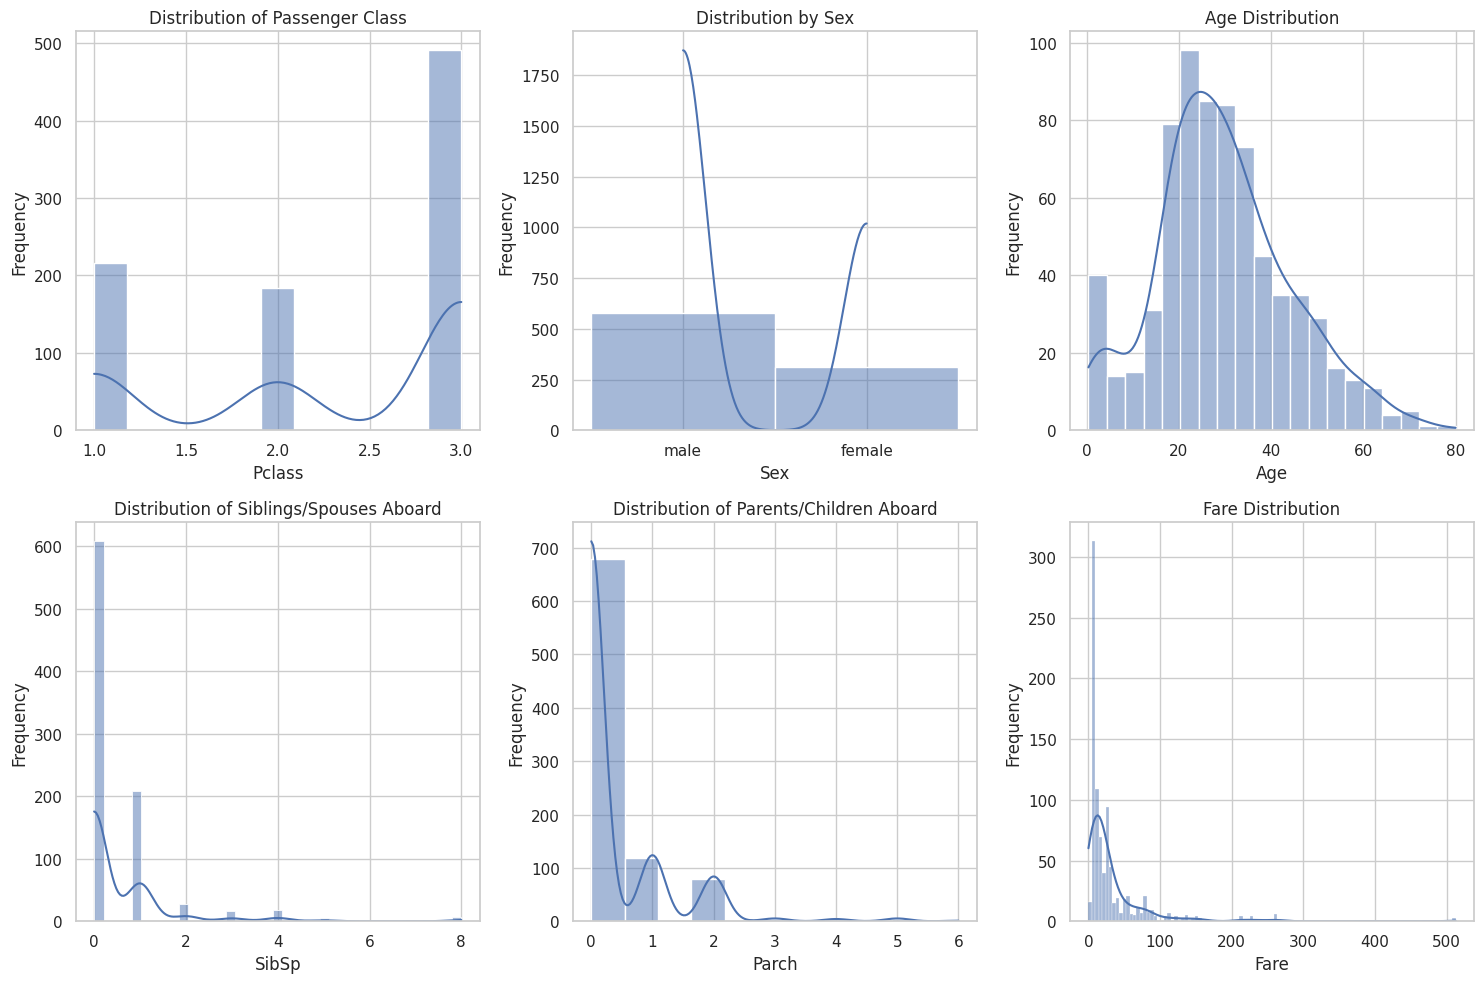

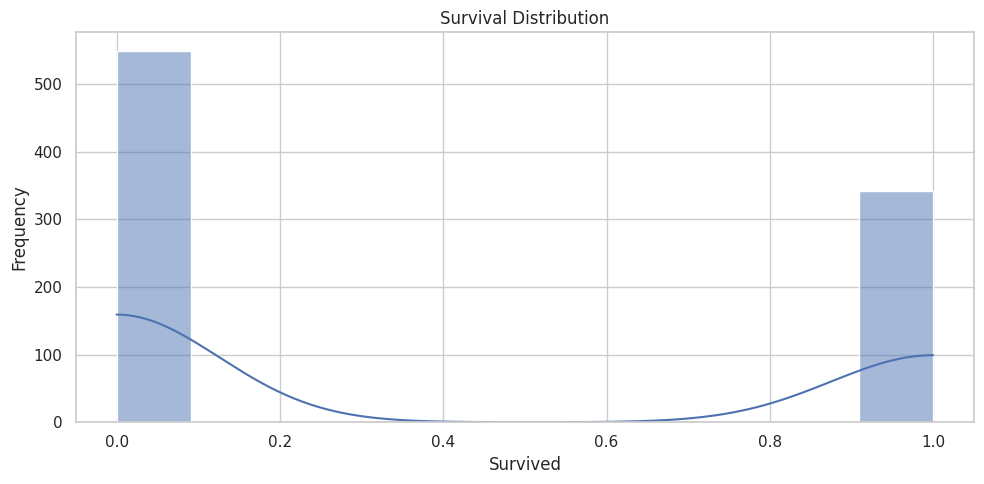

In [34]:
sns.set(style="whitegrid")

def plot_distribution(data, column, title, ax):
    
    sns.histplot(data[column], kde=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Frequency')

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

plot_distribution(train_data, 'Pclass', 'Distribution of Passenger Class', axes[0,0])
plot_distribution(train_data, 'Sex', 'Distribution by Sex', axes[0,1])
plot_distribution(train_data, 'Age', 'Age Distribution', axes[0,2])
plot_distribution(train_data, 'SibSp', 'Distribution of Siblings/Spouses Aboard', axes[1,0])
plot_distribution(train_data, 'Parch', 'Distribution of Parents/Children Aboard', axes[1,1])
plot_distribution(train_data, 'Fare', 'Fare Distribution', axes[1,2])

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
plot_distribution(train_data, 'Survived', 'Survival Distribution', axes)
plt.tight_layout()
plt.show()

Распределение по классам билетов (Pclass): Большинство пассажиров путешествовали в третьем классе.

Распределение по полу (Sex): Количество мужчин превышает количество женщин.

Распределение по возрасту (Age): Возраст пассажиров имеет бимодальное распределение с пиками в районе молодых взрослых и детей.

Распределение количества братьев, сестер/супругов на борту (SibSp): Большинство пассажиров путешествовали без братьев, сестер или супругов.

Распределение количества родителей/детей на борту (Parch): Подавляющее большинство пассажиров путешествовали без детей или родителей.

Распределение стоимости билетов (Fare): Большинство билетов были относительно дешевыми, хотя наблюдается широкий диапазон цен.

Распределение выживших (Survived): Большая часть пассажиров не выжила

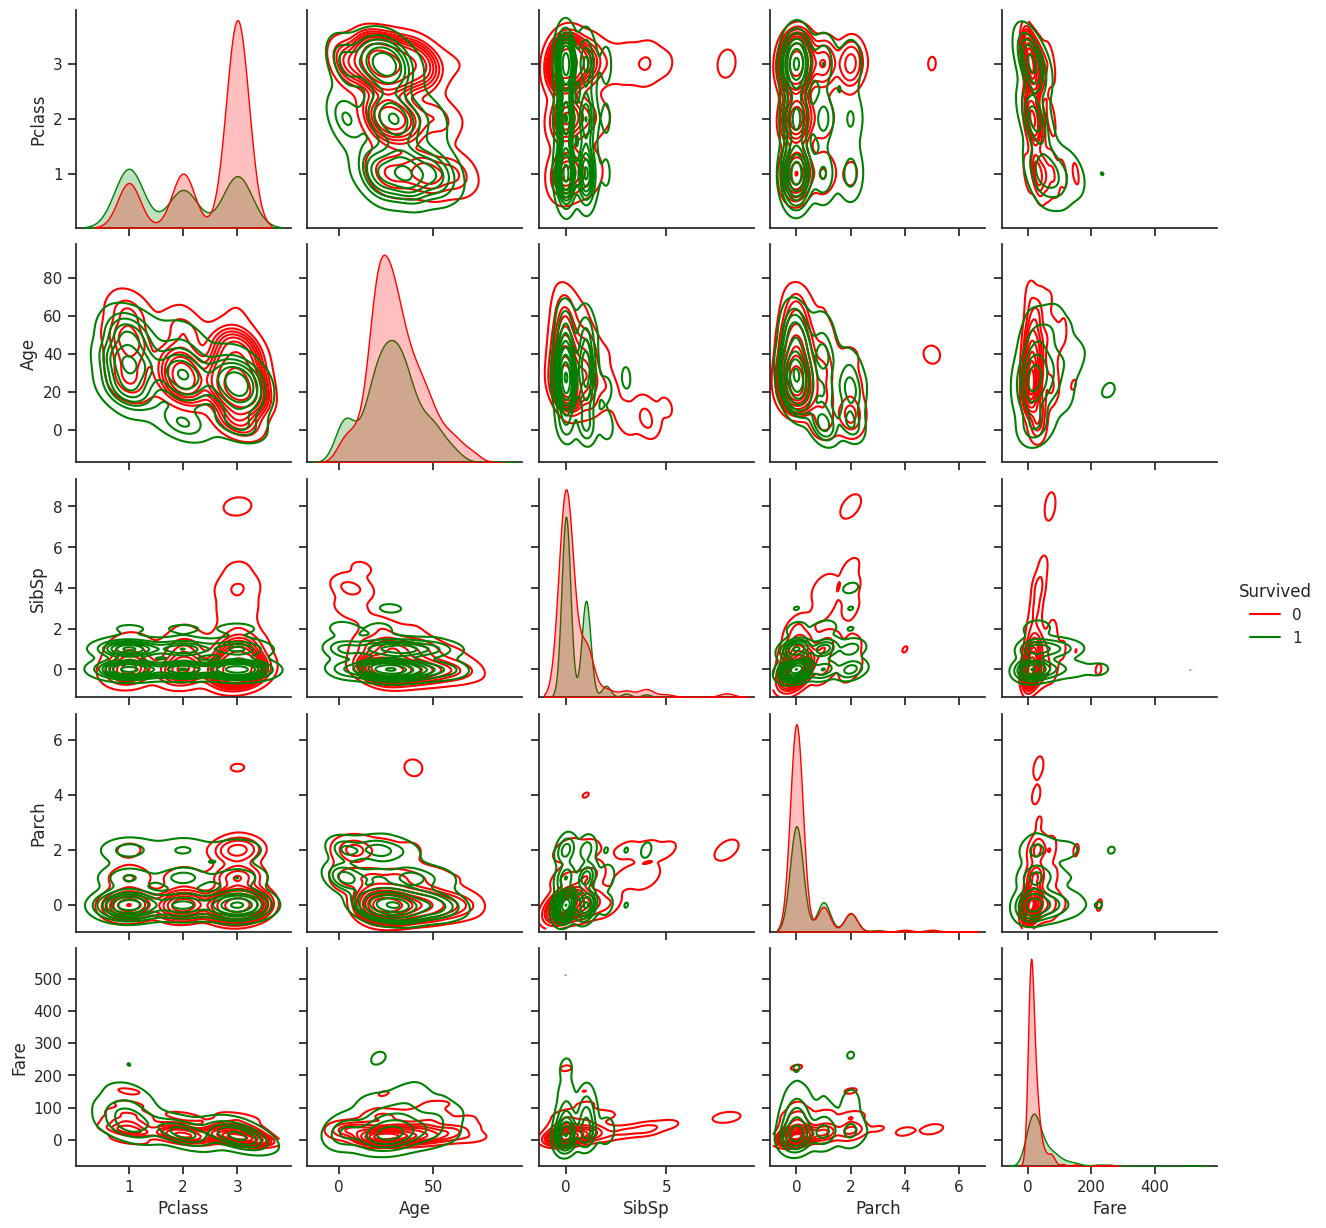

In [43]:
columns_to_plot = train_data[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]

sns.set(style="ticks")
palette = {0: "red", 1: "green"}

sns.pairplot(columns_to_plot, hue="Survived", palette=palette, diag_kind="kde", kind="kde", markers=["o", "s"])
plt.show()

Выживаемость и класс билета (Pclass): Высокий уровень выживаемости наблюдается среди пассажиров первого класса.

Выживаемость и пол (Sex): Женщины имели более высокий шанс на выживание по сравнению с мужчинами.

Выживаемость и возраст (Age): Младшие возрастные группы имеют более высок

## Провести такое же описание пассажиров отдельно для каждого класса билета. Составить средний портрет пассажира каждого класса

In [64]:
grouped_data = train_data.groupby('Pclass').agg({
    'Age': 'mean',
    'SibSp': 'mean',
    'Parch': 'mean',
    'Fare': 'mean',
    'Survived': 'mean',  # наиболее часто встречающееся значение
    'Sex': lambda x: x.mode().iloc[0],
    'Embarked': lambda x: x.mode().iloc[0]
}).reset_index()

for index, row in grouped_data.iterrows():
    print(f"Средний пассажир {row['Pclass']} класса:")
    print(f"Пол: {row['Sex']}")
    print(f"Возраст: {round(row['Age'], 2)} лет.")
    print(f"Место посадки: {row['Embarked']}.")
    print(f"Средняя стоимость билета: {round(row['Fare'], 2)} долларов.")
    print(f"Братья/сестры, супруги на борту: {round(row['SibSp'], 2)}.")
    print(f"Родители/дети на борту: {round(row['Parch'], 2)}.")
    print(f"Процент выживания: {round(row['Survived'] * 100, 2)}%.\n")

Средний пассажир 1 класса:
Пол: male
Возраст: 38.23 лет.
Место посадки: S.
Средняя стоимость билета: 84.15 долларов.
Братья/сестры, супруги на борту: 0.42.
Родители/дети на борту: 0.36.
Процент выживания: 62.96%.

Средний пассажир 2 класса:
Пол: male
Возраст: 29.88 лет.
Место посадки: S.
Средняя стоимость билета: 20.66 долларов.
Братья/сестры, супруги на борту: 0.4.
Родители/дети на борту: 0.38.
Процент выживания: 47.28%.

Средний пассажир 3 класса:
Пол: male
Возраст: 25.14 лет.
Место посадки: S.
Средняя стоимость билета: 13.68 долларов.
Братья/сестры, супруги на борту: 0.62.
Родители/дети на борту: 0.39.
Процент выживания: 24.24%.



## Провести такое же описание пассажиров отдельно для каждого диапазона возраста (<14, 14-21, 21-35, 35-55, >55). Составить средний портрет пассажира каждого возрастного диапазона

In [71]:
bins = [0, 14, 21, 35, 55, float('inf')]
labels = ['<14', '14-21', '21-35', '35-55', '>55']
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)

grouped_data = train_data.groupby('AgeGroup').agg({
    'Pclass': 'mean',
    'Age': 'mean',
    'SibSp': 'mean',
    'Parch': 'mean',
    'Fare': 'mean',
    'Survived': 'mean',  # обычное среднее значение для процента выживания
    'Sex': lambda x: x.mode().iloc[0],
    'Embarked': lambda x: x.mode().iloc[0]
}).reset_index()

for index, row in grouped_data.iterrows():
    print(f"Средний пассажир в возрастной группе {row['AgeGroup']}:")
    print(f"Пол: {row['Sex']}")
    print(f"Возраст: {round(row['Age'], 2)} лет.")
    print(f"Место посадки: {row['Embarked']}.")
    print(f"Средний класс билета: {round(row['Pclass'], 2)}.")
    print(f"Средняя стоимость билета: {round(row['Fare'], 2)} долларов.")
    print(f"Братья/сестры, супруги на борту: {round(row['SibSp'], 2)}.")
    print(f"Родители/дети на борту: {round(row['Parch'], 2)}.")
    print(f"Процент выживания: {round(row['Survived'] * 100, 2)}%.\n")

Средний пассажир в возрастной группе <14:
Пол: male
Возраст: 5.0 лет.
Место посадки: S.
Средний класс билета: 2.63.
Средняя стоимость билета: 31.02 долларов.
Братья/сестры, супруги на борту: 1.82.
Родители/дети на борту: 1.38.
Процент выживания: 59.15%.

Средний пассажир в возрастной группе 14-21:
Пол: male
Возраст: 17.71 лет.
Место посадки: S.
Средний класс билета: 2.53.
Средняя стоимость билета: 28.88 долларов.
Братья/сестры, супруги на борту: 0.52.
Родители/дети на борту: 0.35.
Процент выживания: 36.7%.

Средний пассажир в возрастной группе 21-35:
Пол: male
Возраст: 27.08 лет.
Место посадки: S.
Средний класс билета: 2.37.
Средняя стоимость билета: 27.67 долларов.
Братья/сестры, супруги на борту: 0.33.
Родители/дети на борту: 0.23.
Процент выживания: 38.13%.

Средний пассажир в возрастной группе 35-55:
Пол: male
Возраст: 42.59 лет.
Место посадки: S.
Средний класс билета: 1.88.
Средняя стоимость билета: 48.06 долларов.
Братья/сестры, супруги на борту: 0.38.
Родители/дети на борту: 0.4

## На основе данных о пасажире научиться предсказывать в какой класс он попадет.построить пайплайн для обучения ивалидации модели. Провестиэксперимент с разными моделями logisitc regression, decision tree, svm.

In [17]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

scaler = StandardScaler()

num_columns = ['Age', 'SibSp', 'Parch', 'Fare']
cat_columns = ['Sex', 'Embarked']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', scaler)]), num_columns),
        ('cat', one_hot_encoder, cat_columns)
    ])

X_train = preprocessor.fit_transform(train_data)
X_test = preprocessor.transform(test_data)

y_train = train_data['Pclass']
y_test = train_data['Pclass']

In [18]:
param_grid_lr = {
    'C': [0.1, 1, 10], 
    'max_iter': [1000, 10000], 
    'penalty': ['l2']
}

param_grid_dt = {
    'max_depth': [3, 5, 10], 
    'min_samples_split': [2, 5, 10]
}

param_grid_svm = {
    'C': [0.1, 1, 10], 
    'kernel': ['rbf', 'linear'], 
    'gamma': ['scale', 'auto']
}

# Логистическая регрессия
grid_lr = GridSearchCV(
    LogisticRegression(solver='lbfgs'),
    param_grid_lr, 
    cv=5, 
    scoring='accuracy'
)
grid_lr.fit(X_train, y_train)

# Дерево решений
grid_dt = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid_dt, 
    cv=5, 
    scoring='accuracy'
)
grid_dt.fit(X_train, y_train)

# SVM
grid_svm = GridSearchCV(
    SVC(), 
    param_grid_svm, 
    cv=5, 
    scoring='accuracy'
)
grid_svm.fit(X_train, y_train)

print("Лучшие параметры и результаты:")
print("Логистическая регрессия:", grid_lr.best_params_, grid_lr.best_score_)
print("Дерево решений:", grid_dt.best_params_, grid_dt.best_score_)
print("SVM:", grid_svm.best_params_, grid_svm.best_score_)

Лучшие параметры и результаты:
Логистическая регрессия: {'C': 10, 'max_iter': 1000, 'penalty': 'l2'} 0.819295712761283
Дерево решений: {'max_depth': 10, 'min_samples_split': 5} 0.9360366580880045
SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'} 0.8338773460548616


In [19]:
best_lr_model = grid_lr.best_estimator_
joblib.dump(best_lr_model, 'best_logistic_regression_model.pkl')

best_dt_model = grid_dt.best_estimator_
joblib.dump(best_dt_model, 'best_decision_tree_model.pkl')

best_svm_model = grid_svm.best_estimator_
joblib.dump(best_svm_model, 'best_svm_model.pkl')

['best_svm_model.pkl']

In [23]:
y_pred_lr = grid_lr.predict(X_test)
y_pred_dt = grid_dt.predict(X_test)
y_pred_svm = grid_svm.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    print(f"Модель: {name}")
    print(f"Точность: {accuracy_score(y_true, y_pred)}")

y_test = test_data['Pclass']

evaluate_model("Логистическая регрессия", y_test, y_pred_lr)
evaluate_model("Дерево решений", y_test, y_pred_dt)
evaluate_model("SVM", y_test, y_pred_svm)

Модель: Логистическая регрессия
Точность: 0.8038277511961722
Модель: Дерево решений
Точность: 0.8971291866028708
Модель: SVM
Точность: 0.8253588516746412


## На основе данных о пасажире научиться предсказывать выживет ли он или нет.Построить пайплайн для обучения ивалидации модели. Провестиэксперимент с разными моделями logisitc regression, decision tree, svm.

In [12]:
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

scaler = StandardScaler()

num_columns = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
cat_columns = ['Sex', 'Embarked']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', num_imputer), ('scaler', scaler)]), num_columns),
        ('cat', one_hot_encoder, cat_columns)
    ])
X_train = preprocessor.fit_transform(train_data)
X_test = preprocessor.transform(test_data)

y_train = train_data['Survived']
#y_test = train_data['Survived']

In [13]:
param_grid_lr = {
    'C': [0.1, 1, 10], 
    'max_iter': [1000, 10000], 
    'penalty': ['l2']
}

param_grid_dt = {
    'max_depth': [3, 5, 10], 
    'min_samples_split': [2, 5, 10]
}

param_grid_svm = {
    'C': [0.1, 1, 10], 
    'kernel': ['rbf', 'linear'], 
    'gamma': ['scale', 'auto']
}

# Логистическая регрессия
grid_lr = GridSearchCV(
    LogisticRegression(solver='lbfgs'),
    param_grid_lr, 
    cv=5, 
    scoring='accuracy'
)
grid_lr.fit(X_train, y_train)

# Дерево решений
grid_dt = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid_dt, 
    cv=5, 
    scoring='accuracy'
)
grid_dt.fit(X_train, y_train)

# SVM
grid_svm = GridSearchCV(
    SVC(), 
    param_grid_svm, 
    cv=5, 
    scoring='accuracy'
)
grid_svm.fit(X_train, y_train)

print("Лучшие параметры и результаты:")
print("Логистическая регрессия:", grid_lr.best_params_, grid_lr.best_score_)
print("Дерево решений:", grid_dt.best_params_, grid_dt.best_score_)
print("SVM:", grid_svm.best_params_, grid_svm.best_score_)

Лучшие параметры и результаты:
Логистическая регрессия: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'} 0.7923796371853618
Дерево решений: {'max_depth': 5, 'min_samples_split': 5} 0.815931203314293
SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} 0.8282844768062269


In [14]:
best_lr_model = grid_lr.best_estimator_
joblib.dump(best_lr_model, 'best_logistic_regression_model.pkl')

best_dt_model = grid_dt.best_estimator_
joblib.dump(best_dt_model, 'best_decision_tree_model.pkl')

best_svm_model = grid_svm.best_estimator_
joblib.dump(best_svm_model, 'best_svm_model.pkl')

['best_svm_model.pkl']

In [15]:
best_lr_model = joblib.load('best_logistic_regression_model.pkl')
best_dt_model = joblib.load('best_decision_tree_model.pkl')
best_svm_model = joblib.load('best_svm_model.pkl')

y_pred_lr = best_lr_model.predict(X_test)
y_pred_dt = best_dt_model.predict(X_test)
y_pred_svm = best_svm_model.predict(X_test)